# Neural Network on a Donut

In the following notebook, we'll be building a simple Feed-Forward Neural Network from my FromScratch module and using it to fit the Donut Distribution without using any sort of basis function. Instead, we'll see that the Neural Network effectively learns to approximate it anyway. First, we'll import numpy and pyplot along with the classifier, loss function, an optimizer, and the distribution.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from FromScratchModule.NNet import Layer, OutputLayer
from FromScratchModule.Activation.Class import Sigmoid, Linear, SoftMax
from FromScratchModule.Loss import binary_cross_entropy
from FromScratchModule.Optimizers import RMSProp
from FromScratchModule.Toy import donut

# The Donut

As you can see from the below cells, the distribution is simply a 2-D shape containing an inner disk and outer ring.

In [2]:
# The Donut Distributions as seen in FromScratch.Toy.donut
def Donut(n, r, margin):
    x = np.random.randn(n, 2)
    x_donut = x[np.sqrt(np.sum(x ** 2, axis=1)) > 1] * (r + margin / 2)
    x_hole = x[np.sqrt(np.sum(x ** 2, axis=1)) <= 1] * (r - margin / 2)

    y_hole = np.zeros([x_hole.shape[0], 1])
    y_donut = np.ones([x_donut.shape[0], 1])

    x = np.vstack([x_hole, x_donut])
    y = np.vstack([y_hole, y_donut])
    return x, y

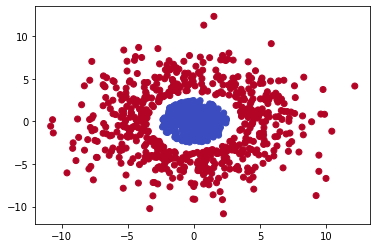

In [3]:
# Here use the donut function to create a donut of radius 3, using 1000 points each for the ring and disk 
x,y = donut(1000, 3, 1)
plt.scatter(x[:,[0]], x[:,[1]], c=y, cmap='coolwarm')

# Building the Neural Net

It's now time to put together a Neural Network using the basic Layer and OutputLayer classes in the module. To do this, we first define each individual layer (two regular Layers and an OutputLayer) and then use the built-in r-shift macro to string them together into one big model. After that, we just route all the essential commands to the internal model that the FeedForwardNeuralNet class is wrapping and then we're good to go.

In [4]:
# A Feed Forward Neural Network class which is tailor made to this specific problem. 
# While defined here, we see that its architecture is built from pieces defined in FromScratchModule.NNet
class FeedForwardNeuralNet:
    def __init__(self, size_in, size_out, hidden_act=Sigmoid(), output_act=Sigmoid()):
        self.layer1 = Layer(size_in, 64, activation_func=hidden_act)
        self.layer2 = Layer(64, 16, activation_func=hidden_act)
        self.output = OutputLayer(16, size_out, output_act)
        
        self.model = self.layer1 >> self.layer2 >> self.output
        
    def get_parameters(self):
        return self.model.get_parameters()
        
    def forward(self, x):
        return self.model.forward(x)
    
    def backward(self, x, y):
        return self.model.backward(x, y)
    
    def predict(self, x, t=0.5):
        return self.forward(x) > t
    

# Running the Model

Now that the wrapper class has been defined, we'll initialize it with an input size of 2 (x0 and x1) and an output size of 1 (the same as our labels). Once initialized, we then define our loss function and instantiate a custom built RMSProp optimizer, passing it our model's parameter dictionary. The final step is to run a simple training process where we just train for 10000 short epochs and then plot the losses we had along the way.

In [9]:
# We'll initialize our model with input size of 2 (each coordinate) and output dim of 1
# The network effectively determines whether the given point is in the disk or not.
model = FeedForwardNeuralNet(2,1)

In [10]:
# While a two class cross entropy setup exists for this problem, our labels would need to be reshaped for it,
# so we just treat the problem as the binary case once again.
loss_func = binary_cross_entropy
optim = RMSProp(model.get_parameters(), learn_rate=1e-4)

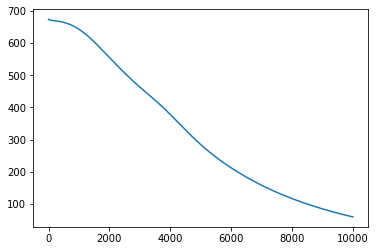

In [11]:
# Each step of training is very simple. First, we find the current error of our model and log it.
# We then call the backward method of our model to compute the gradient with respect to that loss.
# The final step is to let our optimizer update the weights based on the gradients stored during backward.
num_iter = 10000
losses = []
for i in range(num_iter):
    p_hat = model.forward(x)
    losses.append(loss_func(y, p_hat))
    model.backward(x,y)
    optim.update_weights()
plt.plot(losses)

# Results

As you can see from the plot below, the predictions made by the model are spot on. This was a very simple problem however, and most real problems will not see this level of accuracy even with a much more complicated Neural Network, simply because the error is inherant in the data and the problem itself.

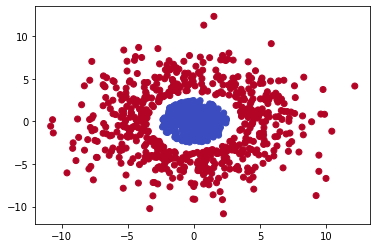

In [12]:
plt.scatter(x[:,[0]], x[:,[1]], c=model.predict(x), cmap='coolwarm')